In [1]:
import numpy as np

from oracles import QuadraticOracle, create_log_reg_oracle, hess_vec_finite_diff
from optimization import conjugate_gradients, lbfgs, hessian_free_newton, gradient_descent

try:
    from utils import LineSearchTool
except ImportError:
    from optimization import LineSearchTool
    
    
import matplotlib.pyplot as plt
import random

import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm

np.random.seed(10)
random.seed(10)
plt.rcParams["figure.figsize"] = (14, 7)

### Задание 4: проверка `hess_vec`

In [2]:
l, d = 100, 70

A = np.random.randn(l, d)
b = np.random.randn(l)

orcl = create_log_reg_oracle(A, b, regcoef=0)
delta = []
for _ in range(1000):
    x, v = np.random.randn(d), np.random.randn(d)
    finite_res = hess_vec_finite_diff(orcl.func, x, v)
    hv_res = orcl.hess_vec(x, v)
    delta.append(np.linalg.norm(finite_res - hv_res))
np.mean(delta)

7.243455739847654e-05

### Эксперимент 1

In [3]:
import string
from scipy import sparse

def generate(n, k):
    a = np.random.uniform(1, k, n)
    ind_1 = np.random.choice(n)
    a[ind_1] = 1
    while True:
        ind_2 = np.random.choice(n)
        if ind_2 != ind_1:
            break
    a[ind_2] = k
    A = sparse.diags(a)
    b = np.random.randint(-k, k, n)
    return A, b

def foo(N=6, K=1070, k_step=50, repeat=10, xlim=1, save=True, nm='fig.png', mode='CG'):
    n_degrees = range(1, N)
    ks = range(10, K, k_step)
    colorlist = ['royalblue', 'lime', 'cyan', 'crimson', 'darkorchid', 'red', 'midnightblue']
    assert len(colorlist) >= N
    fig = plt.figure(figsize=(14, 7))
    for rep in tqdm(range(1, repeat)):
        for_each_n = []
        for deg in n_degrees:
            n = 10 ** deg
            forn_k_iters = []
            for k in ks:
                A, b = generate(n, k)
                orcl = QuadraticOracle(A, b)
                x_start = np.random.uniform(-xlim, xlim, n)
                if mode == 'CG':
                    _, msg, history = conjugate_gradients(lambda x: A @ x, b, x_start, trace=True)
                elif mode == 'GD':
                    _, msg, history = gradient_descent(orcl, x_start, trace=True)

                if msg == 'success':
                    forn_k_iters.append(len(history['time']) - 1)
                else:
                    forn_k_iters.append(0)
            for_each_n.append(forn_k_iters)
            if rep == 1:
                plt.plot(ks, for_each_n[deg-1], label='n={0}'.format(10 ** deg), color=colorlist[deg-1], linewidth=3)
            else:
                plt.plot(ks, for_each_n[deg-1], color=colorlist[deg-1], alpha=1/rep)

    plt.grid()
    plt.legend(fontsize='large')
    plt.title('Dependency for ' + mode + ': iters from vec. dim and cond. num. of A')
    plt.xlabel('Cond. Number')
    plt.ylabel('Iterations')
    plt.show()
    fig.savefig(nm) 

#### CG

  0%|          | 0/9 [00:00<?, ?it/s]

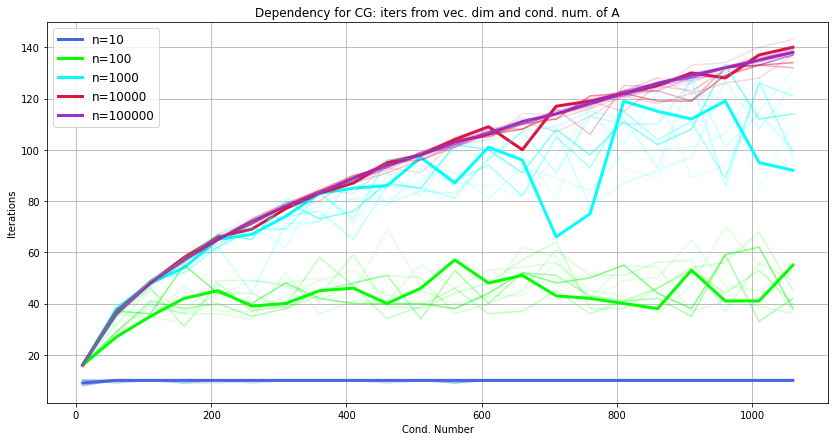

In [4]:
foo(xlim=10, nm='CG exp1.png')

#### GD

  0%|          | 0/9 [00:00<?, ?it/s]

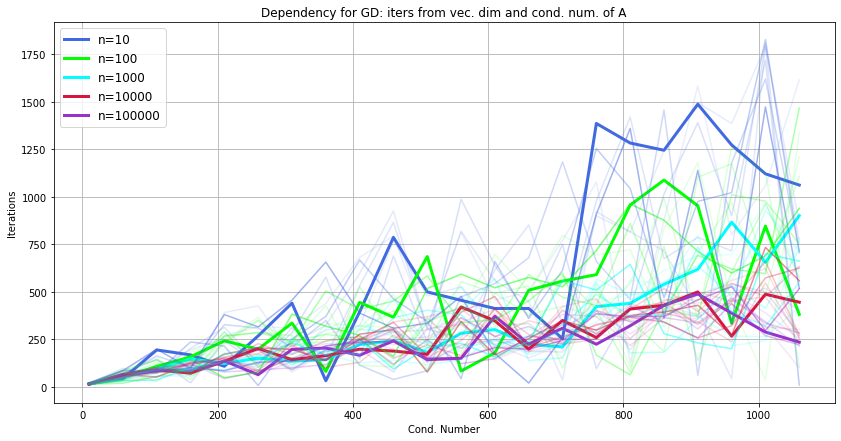

In [5]:
foo(xlim=0.05, nm='GD exp1 close.png', mode='GD')

  0%|          | 0/9 [00:00<?, ?it/s]

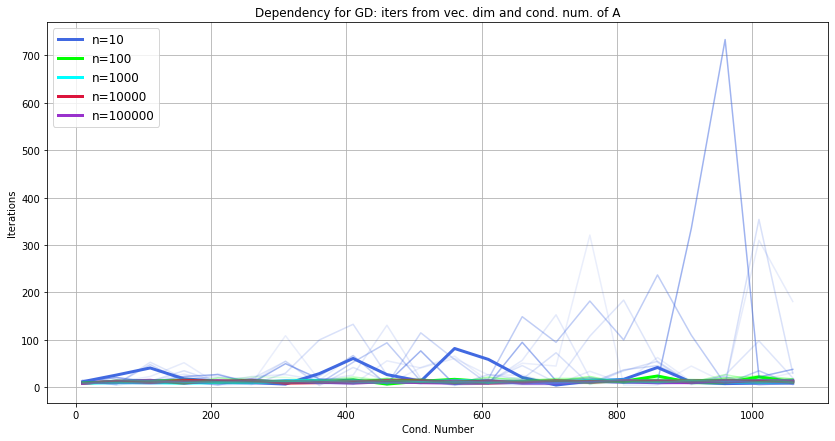

In [6]:
foo(xlim=50, nm='GD exp1 far.png', mode='GD')

### Эксперимент 2

$l$ -- размер хранимой памяти ($l$ пар векторов $s, y$), $n$ -- размерность вектора.
По памяти: храним $2ln$ памяти в истории (до $l$-той итерации), что есть $O(ln)$. В программной реализации в рекурсионный алгоритм я передаю копию истории, которая внутри алгоритма урезается на каждом запуске. Кроме того, на каждой итерации хранится константное число векторов, что тоже $\Theta(n)$. Итого: $O(ln)$.

По времени на 1 итерацию без учета сложности вызова оракула (самой дорогостоящей процедуры):
* Векторные операции, такие как подсчет скалярного произведение, нормы, суммы и умножение на константу -- $\Theta(n)$. Квадратичной сложности нигде не возникает;
* Рекурсивный алгоритм: не более чем $l$ вызовов;
* Каждый рекурсивный вызов -- $\Theta(n)$ времени.

Таким образом, общее время в худшем случае: $l\Theta(n) + \Theta(n) = O(ln)$

In [7]:
import zipfile
import wget
import os

# os.mkdir('data')
# filenames = ['news20.binary.bz2']
# for filename in filenames:
#     wget.download('https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/' + filename, filename)
#     os.replace(filename, 'data/' + filename)

In [8]:
from libsvm.svmutil import *
from sklearn.datasets import load_svmlight_file
X, y = load_svmlight_file('data/news20.binary.bz2')

In [9]:
ls = [0, 1, 5, 10, 25, 50, 75, 100]

m = X.shape[1]
orcl = create_log_reg_oracle(X, y, regcoef=1/m)
x = np.zeros(m)

  0%|          | 0/8 [00:00<?, ?it/s]

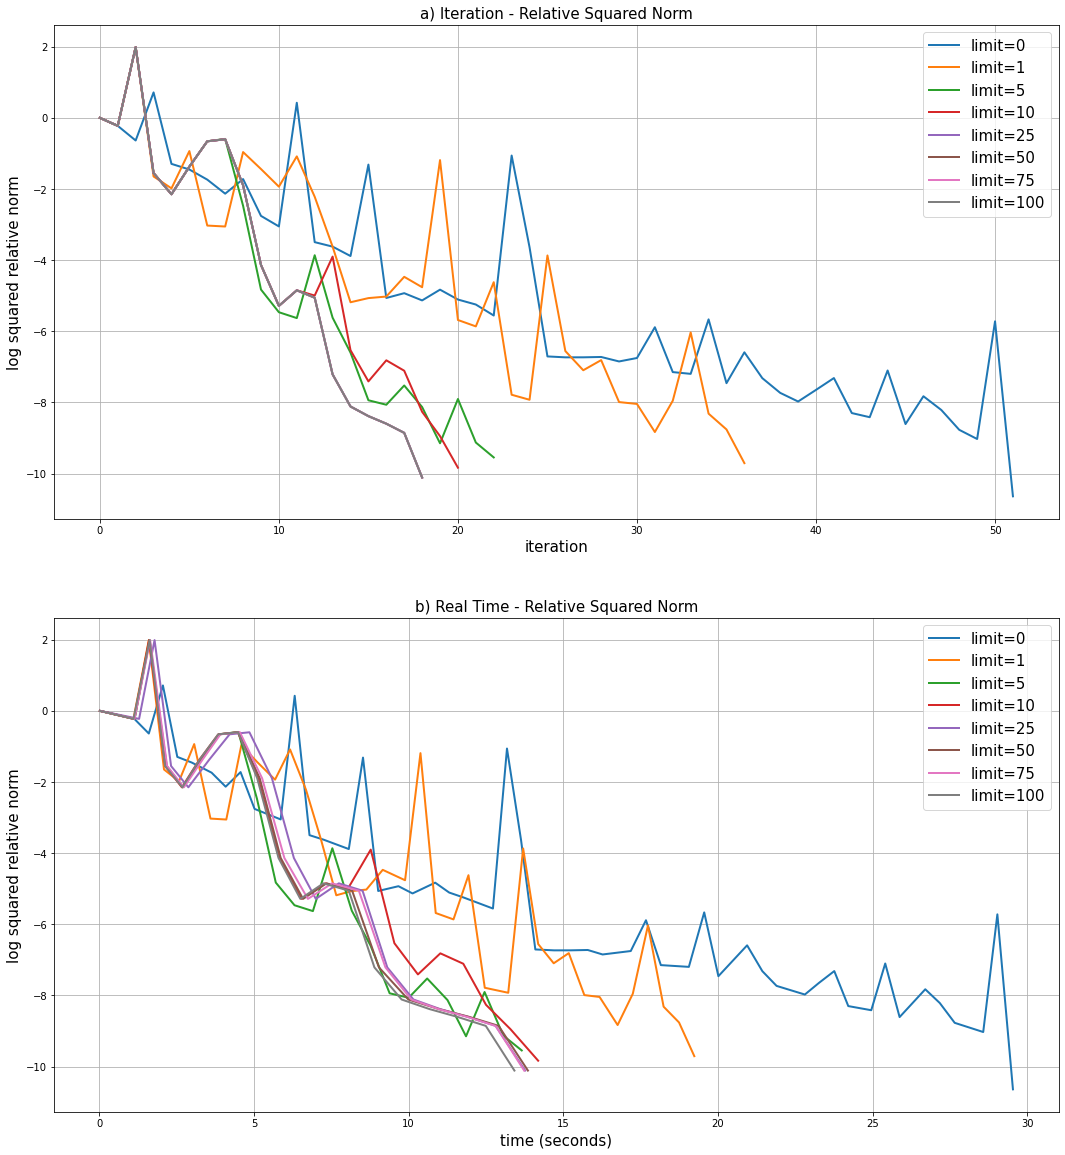

In [10]:
fs = 15
fig, axes = plt.subplots(nrows=2, figsize=(18, 20))
for l in tqdm(ls):
    _, msg, history = lbfgs(orcl, x, memory_size=l, trace=True)
    if msg != 'success':
        print('Failed for memory_size =', l)
        continue
    
    h_len = len(history['time'])
    rel_norms = 2 * np.log(np.array(history['grad_norm']) / history['grad_norm'][0])
    axes[0].plot(np.arange(h_len), rel_norms, label='limit={0}'.format(l), linewidth=2)
    axes[1].plot(history['time'], rel_norms, label='limit={0}'.format(l), linewidth=2)
    
axes[0].set_xlabel('iteration', fontsize=fs)
axes[0].set_ylabel('log squared relative norm', fontsize=fs)
axes[0].set_title('a) Iteration - Relative Squared Norm', fontsize=fs)

axes[1].set_xlabel('time (seconds)', fontsize=fs)
axes[1].set_ylabel('log squared relative norm', fontsize=fs)
axes[1].set_title('b) Real Time - Relative Squared Norm', fontsize=fs)

for ax in axes:
    ax.legend(fontsize=fs)
    ax.grid()

plt.show()
fig.savefig('2exp.png') 

### Эксперимент 3

In [11]:
filenames = ['w8a', 'gisette_scale.bz2', 'real-sim.bz2', 'rcv1_train.binary.bz2']
# for filename in filenames:
#     wget.download('https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/' + filename, filename)
#     os.replace(filename, 'data/' + filename)

In [12]:
# filenames.append('news20.binary.bz2')

In [13]:
filenames = ['data/' + name for name in filenames]

  0%|          | 0/4 [00:00<?, ?it/s]

Dataset: w8a


  0%|          | 0/3 [00:00<?, ?it/s]

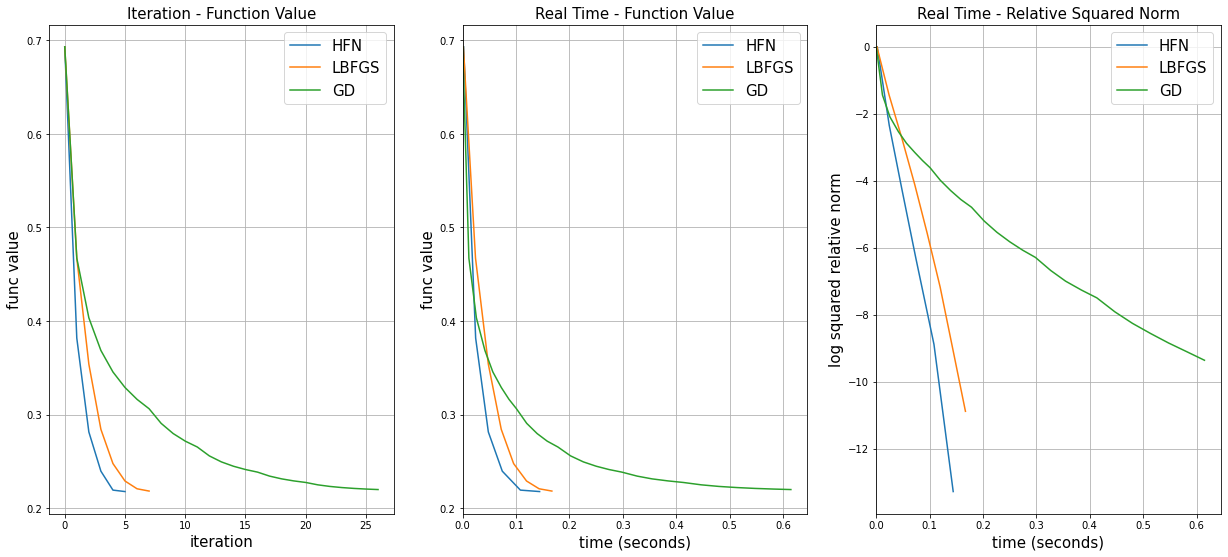

Dataset: gisette_scale


  0%|          | 0/3 [00:00<?, ?it/s]

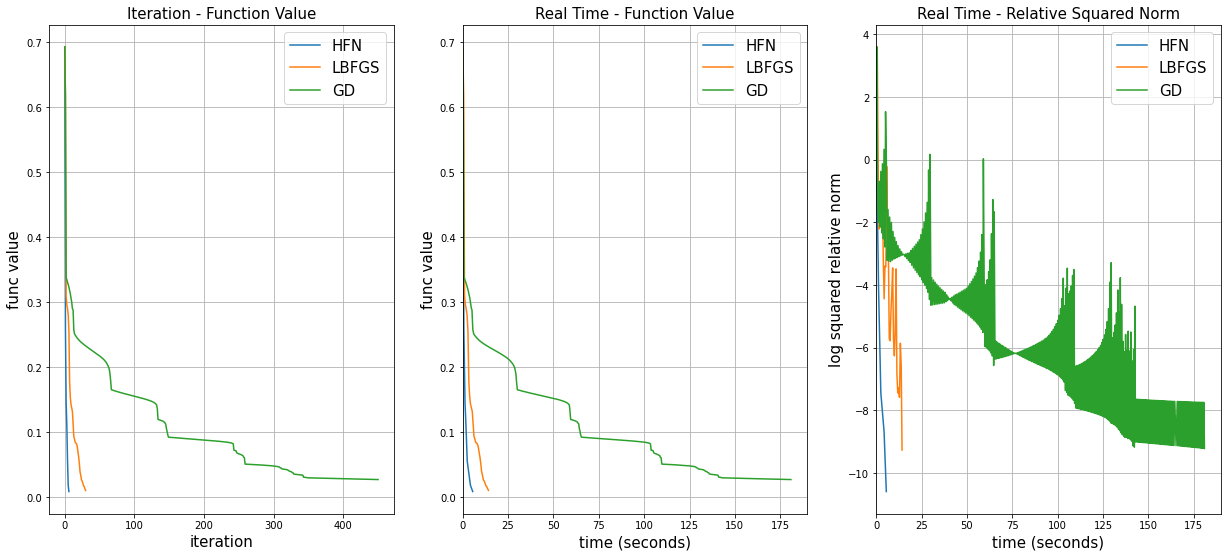

Dataset: real-sim


  0%|          | 0/3 [00:00<?, ?it/s]

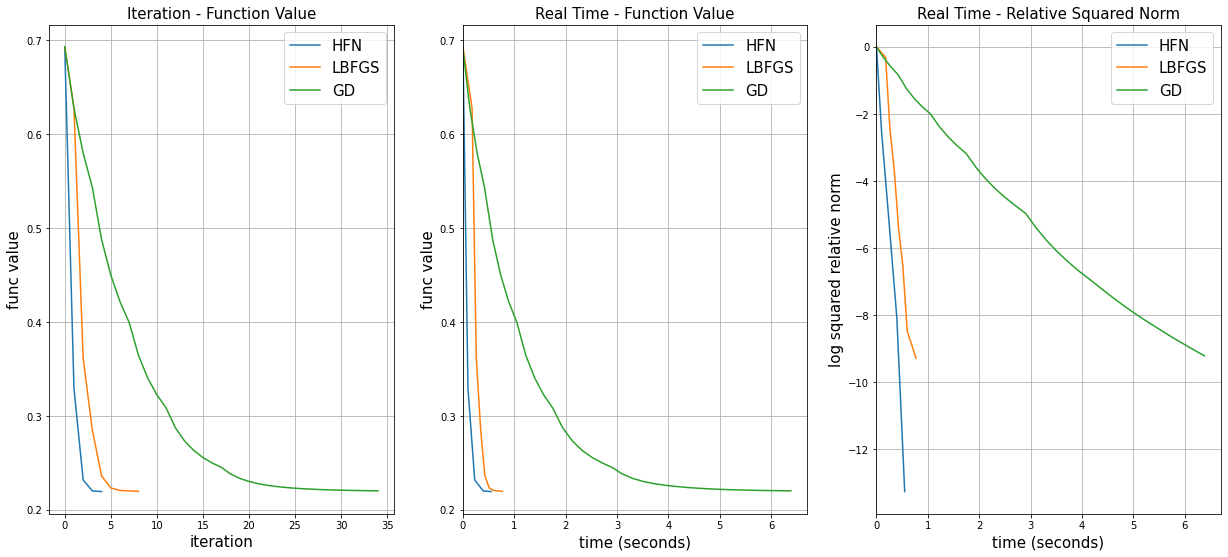

Dataset: rcv1_train.binary


  0%|          | 0/3 [00:00<?, ?it/s]

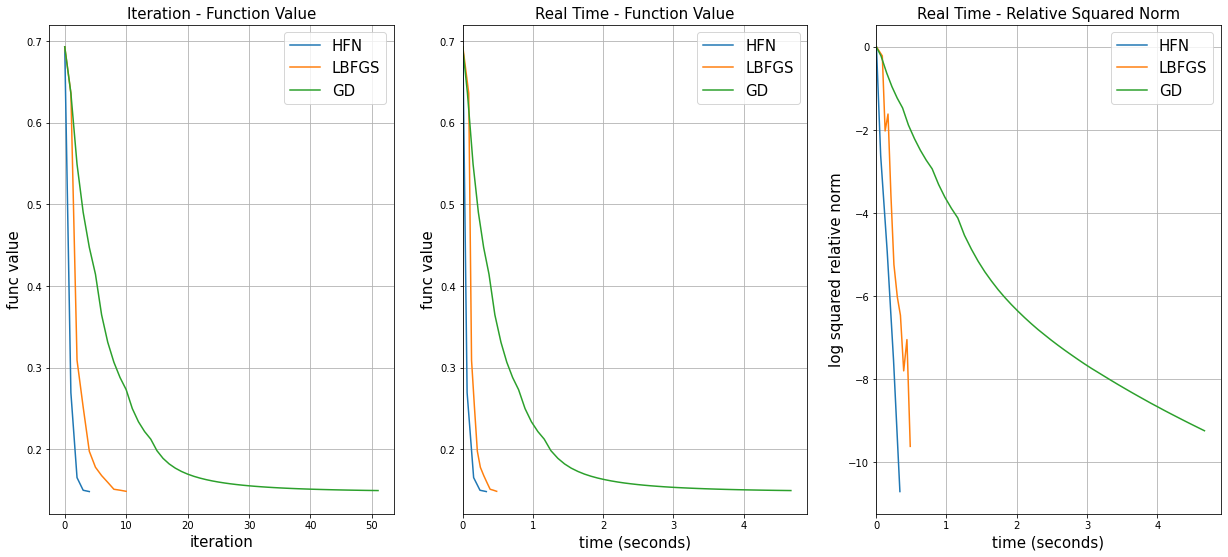

In [14]:
fs = 15

for dataset in tqdm(filenames):
    print('Dataset:', dataset.split('/')[-1].split('.bz2')[0])
    fig, axes = plt.subplots(ncols=3, figsize=(21, 9))
    
    X, y = load_svmlight_file(dataset)
    m = X.shape[1]
    orcl = create_log_reg_oracle(X, y, regcoef=1/m)
    x = np.zeros(m)
    
    hist = {}
    _, msg_hfn, hist['HFN'] = hessian_free_newton(orcl, x, trace=True)
    _, msg_lbfgs, hist['LBFGS'] = lbfgs(orcl, x, trace=True)
    _, msg_gd, hist['GD'] = gradient_descent(orcl, x, trace=True)
    
    for mth in tqdm(['HFN', 'LBFGS', 'GD']):
        h_len = len(hist[mth]['time'])
        rel_norms = 2 * np.log(np.array(hist[mth]['grad_norm']) / hist[mth]['grad_norm'][0])
        axes[0].plot(np.arange(h_len), hist[mth]['func'], label=mth)
        axes[1].plot(hist[mth]['time'], hist[mth]['func'], label=mth)
        axes[2].plot(hist[mth]['time'], rel_norms, label=mth)
        
    
    for i, labels in enumerate([('iteration', 'func value', 'Iteration - Function Value'), 
                   ('time (seconds)', 'func value', 'Real Time - Function Value'),
                   ('time (seconds)', 'log squared relative norm', 'Real Time - Relative Squared Norm')]):
        axes[i].set_xlabel(labels[0], fontsize=fs)
        axes[i].set_ylabel(labels[1], fontsize=fs)
        axes[i].set_title(labels[2], fontsize=fs)
        
    
    for i in range(2):
        axes[i + 1].set_xlim(0.0)
    
    for ax in axes:
        ax.legend(fontsize=fs)
        ax.grid()
    plt.show()
    fig.savefig('fig ' + dataset.split('.')[0][5:] + '.png')

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset: news20.binary


  0%|          | 0/3 [00:09<?, ?it/s]

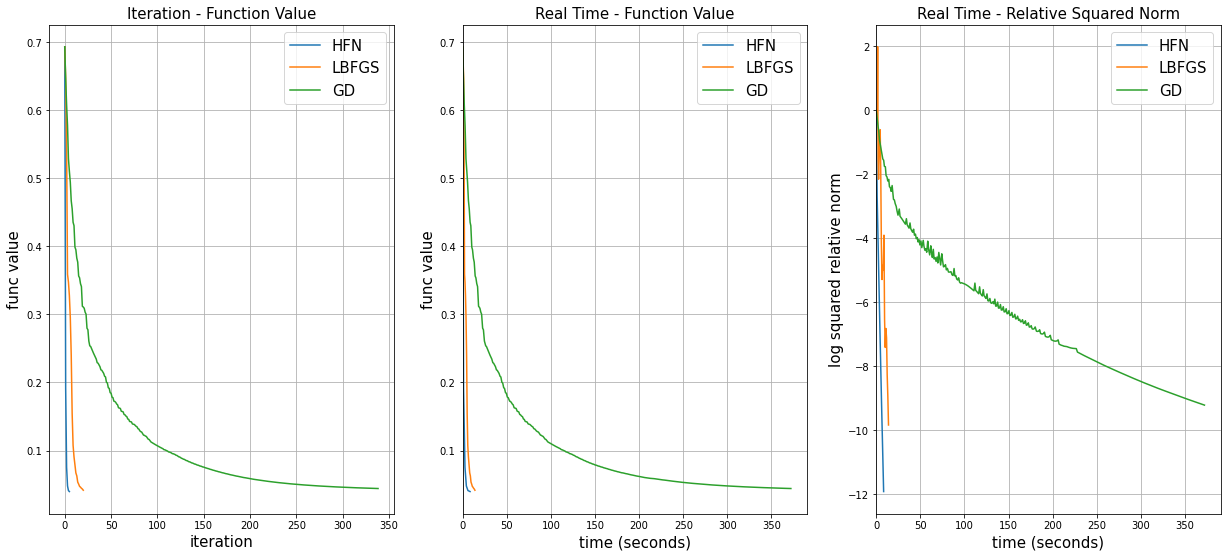

In [15]:
filenames = ['data/news20.binary.bz2']

for dataset in tqdm(filenames):
    print('Dataset:', dataset.split('/')[-1].split('.bz2')[0])
    fig, axes = plt.subplots(ncols=3, figsize=(21, 9))
    
    X, y = load_svmlight_file(dataset)
    m = X.shape[1]
    orcl = create_log_reg_oracle(X, y, regcoef=1/m)
    x = np.zeros(m)
    
    hist = {}
    _, msg_hfn, hist['HFN'] = hessian_free_newton(orcl, x, trace=True)
    _, msg_lbfgs, hist['LBFGS'] = lbfgs(orcl, x, trace=True)
    _, msg_gd, hist['GD'] = gradient_descent(orcl, x, trace=True)
    
    for mth in tqdm(['HFN', 'LBFGS', 'GD']):
        h_len = len(hist[mth]['time'])
        rel_norms = 2 * np.log(np.array(hist[mth]['grad_norm']) / hist[mth]['grad_norm'][0])
        axes[0].plot(np.arange(h_len), hist[mth]['func'], label=mth)
        axes[1].plot(hist[mth]['time'], hist[mth]['func'], label=mth)
        axes[2].plot(hist[mth]['time'], rel_norms, label=mth)
        
    
    for i, labels in enumerate([('iteration', 'func value', 'Iteration - Function Value'), 
                   ('time (seconds)', 'func value', 'Real Time - Function Value'),
                   ('time (seconds)', 'log squared relative norm', 'Real Time - Relative Squared Norm')]):
        axes[i].set_xlabel(labels[0], fontsize=fs)
        axes[i].set_ylabel(labels[1], fontsize=fs)
        axes[i].set_title(labels[2], fontsize=fs)
        
    
    for i in range(2):
        axes[i + 1].set_xlim(0.0)
    
    for ax in axes:
        ax.legend(fontsize=fs)
        ax.grid()
    plt.show()
    fig.savefig('fig ' + dataset.split('.')[0][5:] + '.png')

In [16]:
filenames = ['w8a', 'gisette_scale.bz2', 'real-sim.bz2', 'rcv1_train.binary.bz2', 'news20.binary.bz2']
filenames = ['data/' + name for name in filenames]

for dataset in filenames:
    X, y = load_svmlight_file(dataset)
    print('Dataset: ' + dataset.split('/')[-1].split('.bz2')[0] + ', X.shape:', X.shape)

Dataset: w8a, X.shape: (49749, 300)
Dataset: gisette_scale, X.shape: (6000, 5000)
Dataset: real-sim, X.shape: (72309, 20958)
Dataset: rcv1_train.binary, X.shape: (20242, 47236)
Dataset: news20.binary, X.shape: (19996, 1355191)


### Не относится к заданию

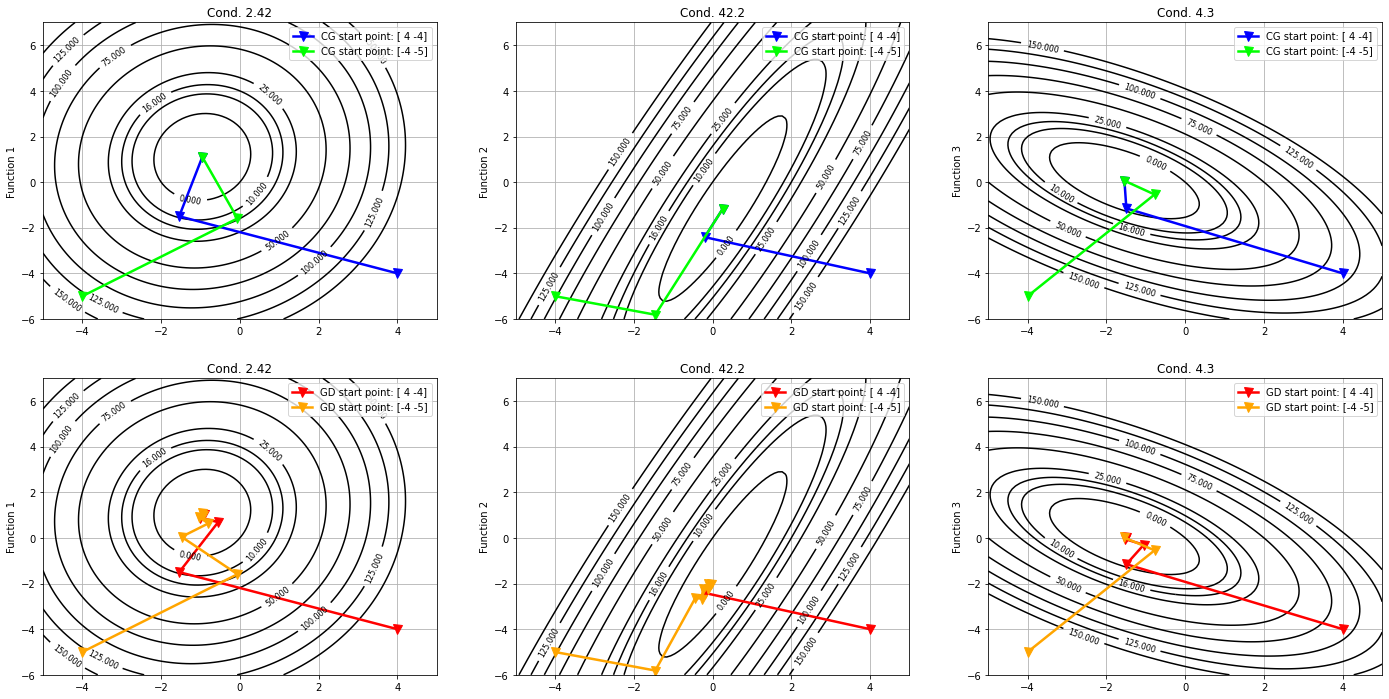

In [17]:
def plot_levels(func, xrange=None, yrange=None, levels=None, ax=None):
    if ax is None:
        ax = plt.gca()
    
    if xrange is None:
        xrange = [-6, 6]
    if yrange is None:
        yrange = [-5, 5]
    if levels is None:
        levels = [0, 0.25, 1, 4, 9, 16, 25]

    x = np.linspace(xrange[0], xrange[1], 100)
    y = np.linspace(yrange[0], yrange[1], 100)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros(X.shape)
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            Z[i, j] = func(np.array([X[i, j], Y[i, j]]))

    CS = ax.contour(X, Y, Z, levels=levels, colors='k')
    ax.clabel(CS, inline=1, fontsize=8)
    ax.grid()


def plot_trajectory(func, history, fit_axis=False, label=None, color='red', ax=None):
    if ax is None:
        ax = plt.gca()
    x_values, y_values = zip(*history)
    ax.plot(x_values, y_values, '-v', linewidth=2.5, ms=9.0,
             alpha=1.0, label=label, color=color)

    if fit_axis:
        xmax, ymax = np.max(x_values), np.max(y_values)
        COEF = 1.5
        xrange = [-xmax * COEF, xmax * COEF]
        yrange = [-ymax * COEF, ymax * COEF]
        ax.set_xlim(xrange)
        ax.set_ylim(yrange)


def cond(A):
    return np.linalg.cond(A)



A_1 = np.array([[12, -0.5], [-0.5, 5]])
A_2 = np.array([[25, -9], [-9, 4]])
A_3 = np.array([[10, 7], [7, 13]])

b_1 = np.array([-12, 6])
b_2 = np.array([17, -7])
b_3 = np.array([-15, -10])

x_1 = np.array([4, -4])
x_2 = np.array([-4, -5])
points = [x_1, x_2]



levels_ = [0, 10, 16, 25, 50, 75, 100, 125, 150]
cs_1 = {0:'blue', 1:'lime'}
cs_2 = {0:'red', 1:'orange'}
xrg = [-5, 5]
yrg = [-6, 7]
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(24, 12))
for Ab_ind, [A, b] in enumerate([[A_1, b_1], [A_2, b_2], [A_3, b_3]]):
    orcl = QuadraticOracle(A, b)
    plot_levels(orcl.func, xrange=xrg, yrange=yrg, levels=levels_, ax=axes[0][Ab_ind])
    plot_levels(orcl.func, xrange=xrg, yrange=yrg, levels=levels_, ax=axes[1][Ab_ind])
    
    for ci, X in enumerate(points):
        history_cg = conjugate_gradients(lambda x: A @ x, b, X, trace=True)[-1]
        history_gd = gradient_descent(orcl, X, trace=True)[-1]
        plot_trajectory(orcl.func, history_cg['x'], label='CG start point: {0}'.format(X), color=cs_1[ci], ax=axes[0][Ab_ind])
        plot_trajectory(orcl.func, history_gd['x'], label='GD start point: {0}'.format(X), color=cs_2[ci], ax=axes[1][Ab_ind])
        
    for i in range(2):
        axes[i][Ab_ind].set_title('Cond. {:.3}'.format(cond(A)))
        axes[i][Ab_ind].set_ylabel('Function {0}'.format(Ab_ind + 1))
        axes[i][Ab_ind].legend()
    
    plt.grid(True)
plt.show()